In [270]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.metrics import confusion_matrix, f1_score
import tensorflow as tf
import itertools
print(tf.__version__)

#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd=''
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

2.6.0


In [271]:
company_factor = get_data("""SELECT *
                 FROM tfb103d_project.datamining_alldata_afetl 
                 WHERE stock_report_date < '20213' order by stock_code,stock_report_date;""",'tfb103d_project')

company_factor

,stock_code,stock_report_date,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,...,export_usd_value_37050000306,export_usd_value_848620,export_usd_value_848610,export_usd_value_381800,new_cases_smoothed_USA,new_cases_smoothed_OWID_EUR,new_cases_smoothed_TWN,people_fully_vaccinated_per_hundred_USA,emotion,roe_rate_predict
0,2302,20183,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.74,...,18323,61504,3021,107270,0.00,0.00,0.00,0.00,0.329644,0.42
1,2302,20184,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,1.34,...,27973,93168,2669,112119,0.00,0.00,0.00,0.00,0.318859,-0.20
2,2302,20191,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,1.51,...,17192,72410,4024,96978,0.00,0.00,0.00,0.00,0.379849,0.85
3,2302,20192,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,2.17,...,19788,77517,3432,98799,0.00,0.00,0.00,0.00,0.388058,0.17
4,2302,20193,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,4.32,...,19911,118643,3547,90681,0.00,0.00,0.00,0.00,0.397925,-0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,8299,20202,24.76,10.91,10.95,299.48,181.73,27.74,4.28,6.49,...,23548,83758,1824,93532,26218.70,22066.62,4.34,0.00,0.477129,6.07
1784,8299,20203,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,5.25,...,21166,88039,509,96949,50018.10,27565.47,4.07,0.00,0.599184,11.76
1785,8299,20204,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,11.28,...,26507,125111,2209,104276,134753.31,197678.98,7.04,0.29,0.483713,4.71
1786,8299,20211,29.71,13.09,0.17,281.91,191.93,29.32,1.95,-3.70,...,21595,173860,3284,108639,120178.33,179397.16,6.49,15.95,0.483452,6.52


In [272]:
# 輸入數據調成標準值以免各特徵影響不同
def mean_norm(df_input):
    return df_input.apply(lambda x: ((x-df_input.mean())/ df_input.std()))

In [273]:
#標準化
a, b = company_factor.shape
for i in range(b):
    if i > 1:
        company_factor[company_factor.columns[i]] = mean_norm(company_factor[company_factor.columns[i]])
    else:
        pass
# company_factor.to_csv('company_factor_to20212.CSV')

In [274]:
# 將數值轉為 1,0 編碼，作為模型的預測目標(應變數)
def encoding(r,th):
    if r >= th:
        return 1
    else:
        return 0
    
#定義股東權益報酬率 >平均者為表現良好
m2 = company_factor['roe_rate_predict'].mean()
company_factor['roe_rate_predict'] = company_factor.apply(lambda r : encoding(r['roe_rate_predict'],m2), axis = 1)

In [275]:
#取 2021 Q2 Data 與 2021 Q3 ROE
company_factor_20212 = company_factor[company_factor.stock_report_date == "20212"]
company_factor_20212

,stock_code,stock_report_date,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,...,export_usd_value_37050000306,export_usd_value_848620,export_usd_value_848610,export_usd_value_381800,new_cases_smoothed_USA,new_cases_smoothed_OWID_EUR,new_cases_smoothed_TWN,people_fully_vaccinated_per_hundred_USA,emotion,roe_rate_predict
11,2302,20212,0.175804,0.160660,0.711734,-0.447935,-0.408376,-0.775931,-0.246212,-0.319791,...,1.326561,1.430512,0.232277,1.830673,0.131507,0.80716,3.307942,3.14823,0.566844,0
23,2303,20212,0.030827,0.334951,0.054007,-0.288129,-0.264990,0.636666,-0.148856,0.677748,...,1.326561,1.430512,0.232277,1.830673,0.131507,0.80716,3.307942,3.14823,0.566844,1
35,2329,20212,-0.406431,0.114733,0.149749,-0.536639,-0.453288,0.823913,-0.207079,0.733838,...,1.326561,1.430512,0.232277,1.830673,0.131507,0.80716,3.307942,3.14823,0.566844,1
47,2330,20212,0.759201,0.550795,0.180915,-0.411290,-0.318285,0.194457,-0.042910,0.624247,...,1.326561,1.430512,0.232277,1.830673,0.131507,0.80716,3.307942,3.14823,0.566844,1
59,2337,20212,0.334348,0.226272,0.267432,-0.427447,-0.463846,0.529500,-0.103996,0.462017,...,1.326561,1.430512,0.232277,1.830673,0.131507,0.80716,3.307942,3.14823,0.566844,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,8150,20212,-0.088954,0.252011,0.401570,-0.342957,-0.270474,0.435876,-0.247167,0.633739,...,1.326561,1.430512,0.232277,1.830673,0.131507,0.80716,3.307942,3.14823,0.566844,1
1751,8261,20212,-0.042437,0.171091,0.512770,-0.395225,-0.345296,0.513601,-0.245258,1.449202,...,1.326561,1.430512,0.232277,1.830673,0.131507,0.80716,3.307942,3.14823,0.566844,1
1763,8271,20212,-0.428138,0.067122,0.563633,-0.336485,-0.482932,0.209177,-0.041956,-3.366775,...,1.326561,1.430512,0.232277,1.830673,0.131507,0.80716,3.307942,3.14823,0.566844,1
1775,8277,20212,-0.606453,-0.923438,-1.360428,0.952538,0.667517,-1.245227,-0.049591,-0.633896,...,1.326561,1.430512,0.232277,1.830673,0.131507,0.80716,3.307942,3.14823,0.566844,0


In [276]:
#取特徵值
X = company_factor_20212[['net_profit_rate','operating_gross_rate', 'roe_rate','roa_rate',
                    'current_rate', 'quick_rate',  'debt_rate',  'receivables_turnover_rate', 
                    'cash_reinvest_rate','export_usd_value_381800','new_cases_smoothed_TWN',
                     'import_usd_value_37079090','avg_import_rate']]
             

y = company_factor_20212['roe_rate_predict']

print("X.shape: " ,X.shape)
# print("X1.shape: " ,X1.shape)
print("y.shape: " ,y.shape)
print('y.sum:',y.sum())

X.shape:  (149, 13)
y.shape:  (149,)
y.sum: 109


<h3>2021 Q3 ROE:  40 筆標記為 0 ； 109 筆為 1
<h3> 基礎準確率為 73.15%

<h1> 以訓練完成的DNN模型 預測 Q3 ROE

In [277]:
#載入模型
model = keras.models.load_model('DNN_F3_model_f')
model.summary()

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_279 (Dense)            (None, 128)               1792      
_________________________________________________________________
dropout_183 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_280 (Dense)            (None, 16)                2064      
_________________________________________________________________
dropout_184 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_281 (Dense)            (None, 1)                 17        
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
_________________________________________________________________


In [282]:
# 利用模型預測
pred = model.predict(X)
P = np.round(pred).flatten()

array([1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.], dtype=float32)

In [279]:
# 評估預測結果 
print("f1_score:",f1_score(y, P))
print("accuray score:", model.evaluate(X, y))

f1_score: 0.9184549356223176
5/5 [==============================] - 0s 749us/step - loss: 0.3513 - accuracy: 0.8725
accuray score: [0.3512900173664093, 0.8724831938743591]


In [286]:
df = pd.read_csv('./randomForest_pre(tree50depth10).csv')
y = df['roe']
P = df['prediction']

Confusion matrix, without normalization
[[ 28  12]
 [  6 103]]


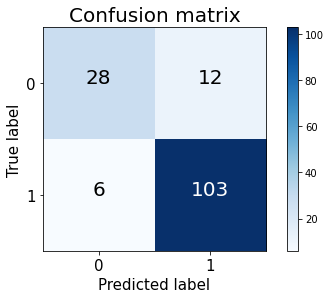

In [287]:
#繪製混淆矩陣
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title,fontsize=20)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, fontsize=15)
  plt.yticks(tick_marks, classes,fontsize=15)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black",fontsize=20)

  plt.tight_layout()
  plt.ylabel('True label',fontsize=15)
  plt.xlabel('Predicted label',fontsize=15)
  plt.show()

cm = confusion_matrix(y, P)
cm
plot_confusion_matrix(cm, list(range(2)))